In [1]:
# Standard library
import datetime
import glob
import os
import warnings

# Suppress non-critical Keras warning
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")

# Utility libraries
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Scikit-learn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import shuffle

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# Image preprocessor: loading, resizing, and normalization
class ImagePreprocessor:
    # Set target image size, normalization, and optional flattening
    def __init__(self, image_size=(64, 64), normalize=True, flatten=False):
        self.image_size = image_size
        self.normalize = normalize
        self.flatten = flatten

    # Load and preprocess all valid image files in the folder
    def load_images_from_folder(self, folder_path, label):
        images, labels = [], []
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img_path = os.path.join(folder_path, filename)
                    img = Image.open(img_path).convert("RGB").resize(self.image_size)
                    img_array = np.asarray(img)
                    # Normalize pixel values if enabled
                    if self.normalize:
                        img_array = img_array / 255.0
                    # Optionally flatten image into 1D vector
                    if self.flatten:
                        img_array = img_array.flatten()
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"[WARN] Could not load {filename}: {e}")
        return images, labels

    # Load penguin and non-penguin images, shuffle combined dataset
    def load_dataset(self, penguin_path, not_penguin_path):
        penguin_imgs, penguin_labels = self.load_images_from_folder(penguin_path, 1)
        not_penguin_imgs, not_penguin_labels = self.load_images_from_folder(not_penguin_path, 0)
        all_images = np.array(penguin_imgs + not_penguin_imgs)
        all_labels = np.array(penguin_labels + not_penguin_labels)
        all_images, all_labels = shuffle(all_images, all_labels, random_state=42)
        # Print dataset summary info after loading
        print(f"[INFO] Loaded {len(penguin_imgs)} penguins and {len(not_penguin_imgs)} non-penguins")
        print(f"[INFO] Final image shape: {all_images[0].shape}")
        return all_images, all_labels


In [3]:
# Penguin classifier: builds, trains, and evaluates CNN
class PenguinClassifier:
    def __init__(self, test_size=0.2):
        self.test_size = test_size
        self.model = self._build_model()

    # Build a simple CNN with 2 conv layers + dropout + batchnorm
    def _build_model(self):
        model = models.Sequential([
            layers.Input(shape=(64, 64, 3)),

            # First conv block (32 filters + max pool)
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(2, 2)),

            # Second conv block (64 filters + max pool)
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(2, 2)),

            # Dropout for regularization to prevent overfitting
            layers.Dropout(0.2),

            # Fully connected layers with dropout and softmax output
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.4),
            layers.Dense(2, activation='softmax')
        ])

        # Compile model using Adam optimizer and sparse crossentropy loss
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    # Train model with train/val/test split and augmentation
    def train(self, X, y, epochs=40, batch_size=32, val_split=0.1):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=self.test_size, stratify=y, random_state=42
        )

        # Further split training data into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=val_split, stratify=y_train, random_state=42
        )

        # Apply data augmentation to increase variation in training data
        datagen = ImageDataGenerator(
            rotation_range=20,
            zoom_range=0.2,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True
        )
        datagen.fit(X_train)

        # Early stopping and LR scheduler callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )

        lr_schedule = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            verbose=1
        )

        # Fit the model on augmented data, with validation tracking
        history = self.model.fit(
            datagen.flow(X_train, y_train, batch_size=batch_size),
            validation_data=(X_val, y_val),
            epochs=epochs,
            callbacks=[lr_schedule],
            verbose=1
        )

        # Save train/val/test data and training history
        self.X_test, self.y_test = X_test, y_test
        self.history = history

        print(f"[INFO] Training stopped at epoch {len(history.history['loss'])}.")
        return history

    # Evaluate test accuracy using held-out test set
    def evaluate(self):
        loss, acc = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        print(f"[INFO] Test Accuracy: {acc:.4f}")
        return acc

    # Predict class labels and softmax probabilities
    def predict(self, X):
        probs = self.model.predict(X)
        return np.argmax(probs, axis=1), probs

    # Save the model to directory in .keras format
    def save_model(self, path="penguin_model.keras"):
        self.model.save(path)


In [4]:
# Initialize preprocessor and load dataset
penguin_path = "../data/penguin"
not_penguin_path = "../data/not_penguin"

# Load dataset from disk using preprocessing class
preprocessor = ImagePreprocessor(image_size=(64, 64), normalize=True, flatten=False)
images, labels = preprocessor.load_dataset(penguin_path, not_penguin_path)

# Build and train the model
classifier = PenguinClassifier()
classifier.train(images, labels, epochs=30)
classifier.evaluate()


[INFO] Loaded 2168 penguins and 2168 non-penguins
[INFO] Final image shape: (64, 64, 3)
Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.6810 - loss: 0.8028 - val_accuracy: 0.5072 - val_loss: 0.7772 - learning_rate: 0.0010
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.7803 - loss: 0.5032 - val_accuracy: 0.5648 - val_loss: 0.6829 - learning_rate: 0.0010
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.8020 - loss: 0.4446 - val_accuracy: 0.6282 - val_loss: 0.6193 - learning_rate: 0.0010
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.8094 - loss: 0.4280 - val_accuracy: 0.7118 - val_loss: 0.5627 - learning_rate: 0.0010
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - accuracy: 0.8353 - loss: 0.3835 - val_accuracy: 0.7983 - val_loss: 0.4515 - learning_rate: 0.0010
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.8322 - loss: 0.3852 - val_accuracy: 0.6715 - val_loss: 0.5898 - learning_rate: 0

0.9412442445755005

[INFO] Saved training curve to ../output/training_curves_20250514_192801.png


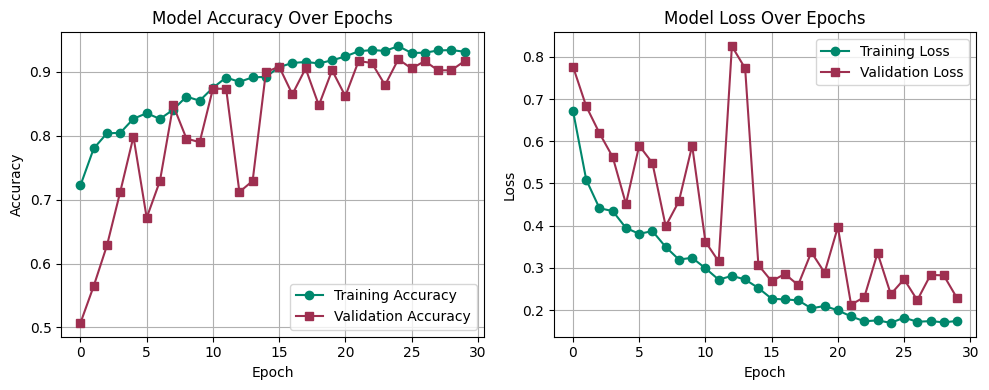

In [5]:
# Save training and evaluation artifacts to timestamped file
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

os.makedirs("../output", exist_ok=True)

history = classifier.history

# Plot training accuracy/loss across epochs
plt.figure(figsize=(10, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='#00876c', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#9e2f50', marker='s')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='#00876c', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='#9e2f50', marker='s')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save figure to output folder
plt.tight_layout()
plot_path = f"../output/training_curves_{timestamp}.png"
plt.savefig(plot_path)
print(f"[INFO] Saved training curve to {plot_path}")
plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
[INFO] Saved confusion matrix to ../output/confusion_matrix_20250514_192801.png


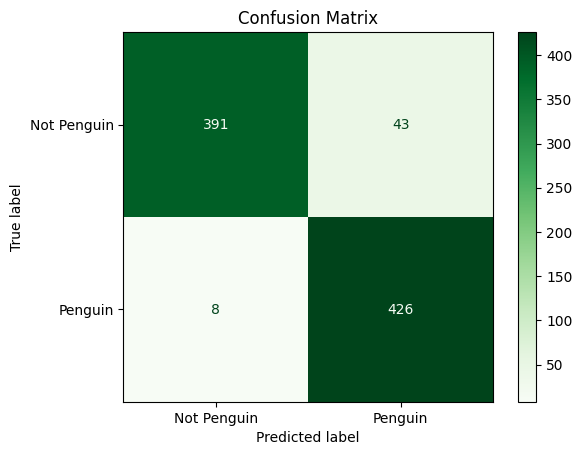

              precision    recall  f1-score   support

 Not Penguin       0.98      0.90      0.94       434
     Penguin       0.91      0.98      0.94       434

    accuracy                           0.94       868
   macro avg       0.94      0.94      0.94       868
weighted avg       0.94      0.94      0.94       868

[INFO] Saved classification report to ../output/classification_report_20250514_192801.txt


In [6]:
# Predict test set and evaluate using confusion matrix
y_pred, _ = classifier.predict(classifier.X_test)

# Plot confusion matrix
cm = confusion_matrix(classifier.y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Penguin", "Penguin"])
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
cm_path = f"../output/confusion_matrix_{timestamp}.png"
plt.savefig(cm_path)
print(f"[INFO] Saved confusion matrix to {cm_path}")
plt.show()

# Classification report
report = classification_report(classifier.y_test, y_pred, target_names=["Not Penguin", "Penguin"])
print(report)

# Save classification report to file
report_path = f"../output/classification_report_{timestamp}.txt"
with open(report_path, "w") as f:
    f.write(report)
print(f"[INFO] Saved classification report to {report_path}")

In [7]:
# Format filename with timestamp, accuracy, etc.
test_acc = classifier.evaluate()
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"penguin_model_acc{test_acc:.2f}_{timestamp}.keras"
model_path = os.path.join("../models", model_filename)

# Save model in new Keras format
classifier.save_model(model_path)
print(f"[INFO] Model saved as {model_path}")

[INFO] Test Accuracy: 0.9412
[INFO] Model saved as ../models\penguin_model_acc0.94_20250514_192804.keras


In [8]:
# Find most recent saved model in .keras format
model_files = sorted(glob.glob("../models/*.keras"), key=os.path.getmtime, reverse=True)

if model_files:
    model_path = model_files[0]
    loaded_model = load_model(model_path)
    print(f"[INFO] Loaded model: {model_path}")
    
    # Optional test prediction
    sample_input = classifier.X_test[:5]
    preds = loaded_model.predict(sample_input)
    print("Sample predictions:", preds)
else:
    print("[ERROR] No .keras model files found in /models/")

[INFO] Loaded model: ../models\penguin_model_acc0.94_20250514_192804.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Sample predictions: [[0.3390158  0.6609842 ]
 [0.00165721 0.99834275]
 [0.844217   0.15578303]
 [0.6706396  0.3293604 ]
 [0.13528931 0.8647106 ]]


In [10]:
# Ensure demo input folder exists
os.makedirs("../demo_input", exist_ok=True)
print("\n[INFO] Drop test images into '../demo_input/' and classify them using the saved model.")

# Function to classify a single image using the trained model
def classify_image_with_model(image_path, model, image_size=(64, 64)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, image_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    img = img.reshape(1, 64, 64, 3)
    pred = model.predict(img, verbose=0)  # suppress model output
    label = np.argmax(pred, axis=1)[0]
    confidence = pred[0][label]
    return "Penguin 🐧" if label == 1 else "Not Penguin ❌", confidence

# Run classification on all demo images
print("\n Classification Results:\n" + "-" * 50)
for file in sorted(os.listdir("../demo_input")):
    if file.lower().endswith((".jpg", ".jpeg", ".png")):
        path = os.path.join("../demo_input", file)
        label, conf = classify_image_with_model(path, loaded_model)
        label_str = f"{label:<15}"  # Pad label to fixed width
        print(f"{file:<20} →  {label_str} (confidence: {conf:.2f})")
print("-" * 50)



[INFO] Drop test images into '../demo_input/' and classify them using the saved model.

 Classification Results:
--------------------------------------------------
Linux_Penguin.png    →  Penguin 🐧       (confidence: 1.00)
artem.jpg            →  Not Penguin ❌   (confidence: 0.99)
freshavacado.png     →  Not Penguin ❌   (confidence: 0.89)
happyfeet.jpg        →  Penguin 🐧       (confidence: 0.98)
jose.jpg             →  Penguin 🐧       (confidence: 1.00)
kenny.png            →  Not Penguin ❌   (confidence: 0.95)
ling.jpg             →  Penguin 🐧       (confidence: 0.64)
--------------------------------------------------
